<a href="https://colab.research.google.com/github/annalithell/asi-project/blob/main/dropout_bayesian_approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dropout as a Bayesian Approximation: An interpretation of Gal & Ghahramani (2016)**

Author: Anna Lithell

# Assignment description

This assignment is a part of the course *Advanced Statistical Inference* held at EURECOM in the spring of 2025 by Dr. Simone Rossi. I've decided to reproduce the results from the paper *Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning*, published in 2016 by Gal and Ghahramani. This Jupyter notebook contains the code associated with the assignment.

🎯 Objectives
- Understand a research paper in the field of (probabilistic) machine learning.
- Be able to apply the basics of the course to reproduce the results.
- Be able to go from equations to code in a more complex setting than the labs.
- Be able to write a short report explaining the paper, the results, and the code.


## The Code

This noteboook provides an interpretation of a neural network using dropout for a regression task, as described in the original paper.

**Installation and set-up**

In [ ]:
# Set-up and install libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Neural Network model**

The following section defines the neural network (NN) architecture used in this experiment and follows a similar architecture as described in the paper. The model consists of four hidden layers, each with 1024 units. ReLU activations are applied after each layer to introduce non-linearity, and a dropout layer with a probability of 0.1 is used after each activation to reduce overfitting.

In [ ]:
class DropoutNet(nn.Module):
    def __init__(self, input_size, hidden_size=1024, num_hidden_layers=4, dropout_prob=0.1, activation='relu'):
        super().__init__()
        act_fn = nn.ReLU() if activation == 'relu' else nn.Tanh()

        layers = [nn.Linear(input_size, hidden_size), act_fn, nn.Dropout(dropout_prob)]
        for _ in range(num_hidden_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), act_fn, nn.Dropout(dropout_prob)]
        layers.append(nn.Linear(hidden_size, 1))  # Output layer

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

**Prepare the data set**

In this experiment, we'll train the neural network with dropout on a regression task using the california housing dataset.


In [ ]:
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target

# standardize features and target
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y.values.reshape(-1,1))

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

The dataset was derived from the 1990 U.S census and contains a total of 8 numeric attributes. They are:

    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

The target variable is the median house value for California districts (expressed in hundreds of thousands of dollars ($100,000)). The dataset can be visualized as follows:



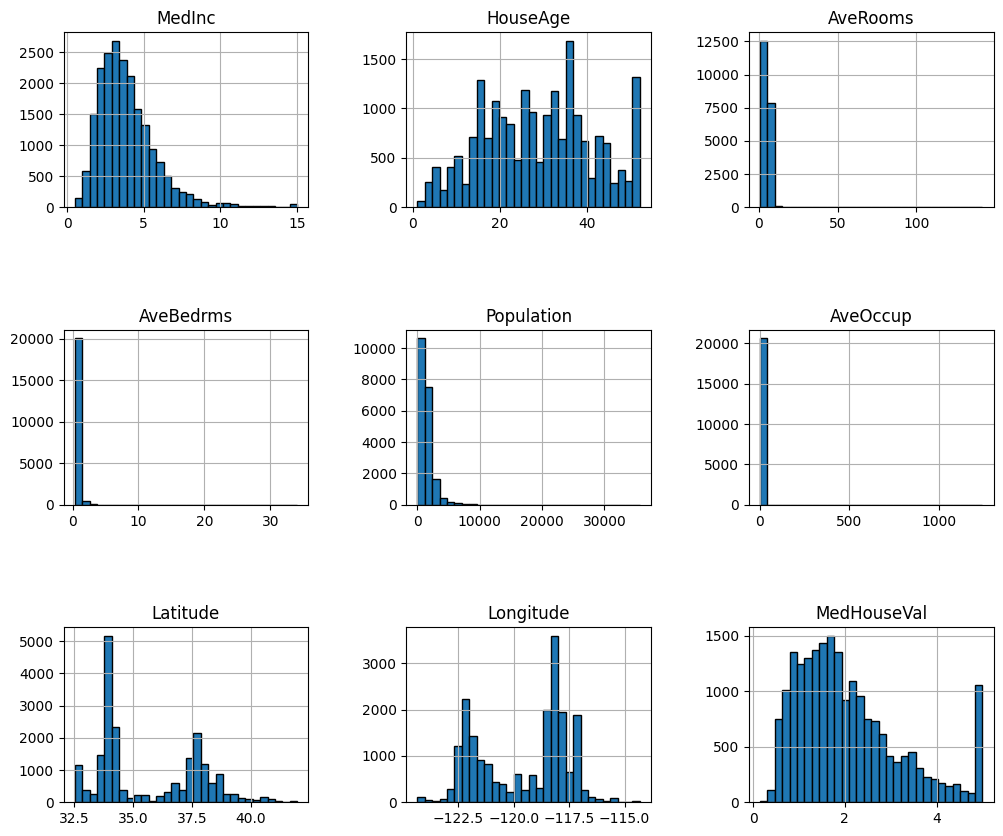

In [ ]:
data.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

For more information about the dataset, please visit the following [website.](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

**Train the network**

We'll use mini-batches of size 64 to train the network. The optimization function used when training is the Mean squared error (MSE) loss function. It is frequently used when performing regression tasks and was provided as an example loss function in the original paper.

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = DropoutNet(input_size=X_train.shape[1], dropout_prob=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
epochs = 1000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(X_train.to(device))
    loss = loss_fn(preds, y_train.to(device))
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0007
Epoch 50, Loss: 0.3187
Epoch 100, Loss: 0.2448
Epoch 150, Loss: 0.2143
Epoch 200, Loss: 0.1953
Epoch 250, Loss: 0.1812
Epoch 300, Loss: 0.1649
Epoch 350, Loss: 0.1549
Epoch 400, Loss: 0.1459
Epoch 450, Loss: 0.1349
Epoch 500, Loss: 0.1258
Epoch 550, Loss: 0.1170
Epoch 600, Loss: 0.1096
Epoch 650, Loss: 0.1017
Epoch 700, Loss: 0.0952
Epoch 750, Loss: 0.0859
Epoch 800, Loss: 0.0806
Epoch 850, Loss: 0.0763
Epoch 900, Loss: 0.0708
Epoch 950, Loss: 0.0669


**Test time**

Apply Monte Carlo (MC) dropout during testing to evaluate the uncertainty of the model.

In [ ]:
def predict_mc(model, data_loader, T=100):
    model.train()  # Important: keep dropout active
    device = next(model.parameters()).device
    all_predictions = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            # make multiple forward passes for each input sample
            batch_predictions = torch.stack([model(X_batch) for _ in range(T)], dim=0)
            all_predictions.append(batch_predictions)

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=1) # Concatenate along the batch dimension (dim=1)

    mean = all_predictions.mean(dim=0)
    std = all_predictions.std(dim=0)
    return mean, std

# Create test_loader
batch_size = 64 # Use same batch size as during training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Call the modified predict_mc function with the test_loader
mean, std = predict_mc(model, test_loader, T=100)

The estimated model mean is the average predicted output for each input sample over T=100 stochastic forward passes, while the estimated variance measures the uncertainty of the model's predictions across T forward passes.

In [ ]:
print("The estimated model mean is", mean)
print("The estimated model variance is", std)

The estimated model mean is tensor([[-1.3375],
        [-1.1830],
        [ 2.6863],
        ...,
        [ 2.1932],
        [-1.1400],
        [-0.1145]], device='cuda:0')
The estimated model variance is tensor([[0.0663],
        [0.1288],
        [0.2473],
        ...,
        [0.1351],
        [0.0569],
        [0.1335]], device='cuda:0')


**Visualize results and evaluate**

What is shown in the residual plot?

*  Residual = Predicted value - True value
*  It shows how much the model over or underestimate a given house price compared to the real price.
*  If residuals cluster near zero and scatter randomly, the model fits well.

What is shown in the scatter plot colored by uncertainty?

* Cool colors = low uncertainty, meaning the model is certain in its prediction
* Warm colors = high uncertainty, the model is unsure or less confident about this prediction


What does the histogram tell us?
* It displays the distribution of uncertainty values predicted by the model
* It gives us an idea if uncertainty in general is low, high or varies a lot.

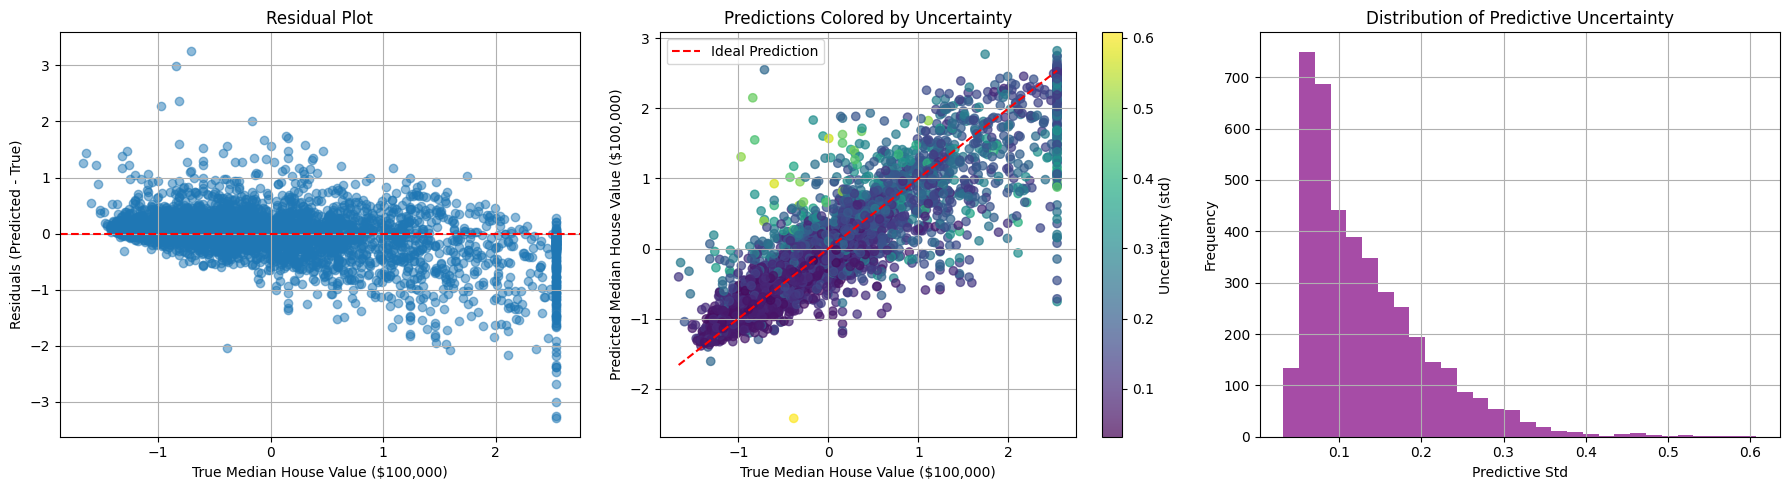

In [ ]:
# y_true_np: true target values (shape [N])
# mean_np: predicted mean values (shape [N])
# std_np: predicted std (uncertainty) values (shape [N])

# Convert tensors to numpy arrays for plotting
mean_np = mean.cpu().numpy()
std_np = std.cpu().numpy()
y_true_np = y_test.cpu().numpy()

# Residual Plot
residuals = mean_np.squeeze() - y_true_np.squeeze()

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_true_np, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('True Median House Value ($100,000)')
plt.ylabel('Residuals (Predicted - True)')
plt.grid(True)

# Scatter plot colored by uncertainty
plt.subplot(1, 3, 2)
sc = plt.scatter(y_true_np.squeeze(), mean_np.squeeze(), c=std_np.squeeze(), cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Uncertainty (std)')
plt.plot([y_true_np.min(), y_true_np.max()],
         [y_true_np.min(), y_true_np.max()],
         'r--', label='Ideal Prediction')
plt.title('Predictions Colored by Uncertainty')
plt.xlabel('True Median House Value ($100,000)')
plt.ylabel('Predicted Median House Value ($100,000)')
plt.legend()
plt.grid(True)

# Histogram of predictive uncertainty
plt.subplot(1, 3, 3)
plt.hist(std_np.squeeze(), bins=30, alpha=0.7, color='purple')
plt.title('Distribution of Predictive Uncertainty')
plt.xlabel('Predictive Std')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()

# Uncomment line to save picture
# plt.savefig('regression_analysis_plots.png')

plt.show()

## Resources
The following websites have clarified certain concepts related to the paper and ML in general.

- https://www.singlestore.com/blog/a-guide-to-softmax-activation-function/ accessed: 2025-04-14
- https://c3.ai/glossary/data-science/root-mean-square-error-rmse/ accessed: 2025-04-14
- https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence accessed: 2025-04-14
- https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html accessed: 2025-05-30
- https://ahmdtaha.medium.com/dropout-as-a-bayesian-approximation-representing-model-uncertainty-in-deep-learning-7a2e49e64a15 accessed: 2025-05-30

The following GitHub repos have provided insight to how experiments related to the paper can be performed.  
- https://github.com/cpark321/uncertainty-deep-learning/blob/master/02.%20Dropout%20as%20a%20Bayesian%20Approximation.ipynb accessed: 2025-05-30
- https://github.com/huyng/incertae/blob/master/mcdrop_regression.ipynb accessed: 2025-05-30
- https://github.com/yaringal/DropoutUncertaintyExps/blob/master/experiment.py accessed: 2025-05-30